<a href="https://colab.research.google.com/github/pgpanagiotidis/Prediction-of-the-stock-s-closing-price/blob/main/Prediction_Closing_Price_of_Stocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the necessary libraries
import pandas as pd
import numpy as np
import plotly.graph_objs as go
from plotly.offline import iplot
from datetime import date
import holidays
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler, RobustScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from datetime import datetime
from torch.cuda import device
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import plotly.offline as pyo
import pylab
import plotly
from plotly.offline import *
import torch.optim as optim

In [ ]:
#Read the data, all prices are in US dollars
df_Pfizer = pd.read_csv('Pfizer.csv')

In [ ]:
#Keep only the columns we are interested in; here are the date and the closing price
def Keepcol(data):
  data=data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
  return data

In [ ]:
#Keep only the necessary columns
df_Pfizer = Keepcol(df_Pfizer)

In [ ]:
#Convert the data to the appropriate format
def Convertdata(data):
    df_new= data.set_index(['Date'])
    df_new.index = pd.to_datetime(df_new.index)
    if not df_new.index.is_monotonic:
        df_new  = df_new.sort_index()
    return df_new

In [ ]:
#The date as index
df_Pfizer = Convertdata(df_Pfizer)

In [ ]:
#Rename the columns
df_Pfizer = df_Pfizer.rename(columns={'Close': 'Closing_price'})

In [ ]:
#Plot all the stocks' closing prices
fig = go.Figure()


fig.add_trace(go.Scatter(x=df_Pfizer.index, y=df_Pfizer.Closing_price,
                    mode='lines',
                    name='Pfizer'))
fig.update_layout(title='Pfizer Stock Closing Price (in US dollars) 1/5/2015-14/5/2021',
                  yaxis_zeroline=False, xaxis_zeroline=False)

fig.show()

In [ ]:
#Create the features 
def generate_time_lags(df, n_lags):
    df_n = df.copy()
    for n in range(1, n_lags + 1):
        df_n[f"lag{n}"] = df_n["Closing_price"].shift(n)
    df_n = df_n.iloc[n_lags:]
    return df_n

In [ ]:
#Create our features, here we use the n past values to predict the following value of the closing price
n= 30
df_generated = generate_time_lags(df_Pfizer, n)
df_generated

,Closing_price,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,lag11,lag12,lag13,lag14,lag15,lag16,lag17,lag18,lag19,lag20,lag21,lag22,lag23,lag24,lag25,lag26,lag27,lag28,lag29,lag30
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-06-15,32.296017,32.457306,32.694496,32.552181,32.267551,32.239090,32.343452,32.485767,32.647060,32.722961,32.789375,32.969639,32.675522,32.542694,32.362431,32.523720,32.599621,32.542694,32.457306,32.239090,32.248577,32.201138,31.812143,32.049335,32.220116,32.277039,31.859583,31.745731,32.371918,32.561668,32.333965
2015-06-16,32.296017,32.296017,32.457306,32.694496,32.552181,32.267551,32.239090,32.343452,32.485767,32.647060,32.722961,32.789375,32.969639,32.675522,32.542694,32.362431,32.523720,32.599621,32.542694,32.457306,32.239090,32.248577,32.201138,31.812143,32.049335,32.220116,32.277039,31.859583,31.745731,32.371918,32.561668
2015-06-17,32.239090,32.296017,32.296017,32.457306,32.694496,32.552181,32.267551,32.239090,32.343452,32.485767,32.647060,32.722961,32.789375,32.969639,32.675522,32.542694,32.362431,32.523720,32.599621,32.542694,32.457306,32.239090,32.248577,32.201138,31.812143,32.049335,32.220116,32.277039,31.859583,31.745731,32.371918
2015-06-18,32.609108,32.239090,32.296017,32.296017,32.457306,32.694496,32.552181,32.267551,32.239090,32.343452,32.485767,32.647060,32.722961,32.789375,32.969639,32.675522,32.542694,32.362431,32.523720,32.599621,32.542694,32.457306,32.239090,32.248577,32.201138,31.812143,32.049335,32.220116,32.277039,31.859583,31.745731
2015-06-19,32.428844,32.609108,32.239090,32.296017,32.296017,32.457306,32.694496,32.552181,32.267551,32.239090,32.343452,32.485767,32.647060,32.722961,32.789375,32.969639,32.675522,32.542694,32.362431,32.523720,32.599621,32.542694,32.457306,32.239090,32.248577,32.201138,31.812143,32.049335,32.220116,32.277039,31.859583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-07,39.580002,39.189999,39.970001,39.950001,39.830002,38.650002,38.599998,38.810001,38.450001,38.680000,38.660000,38.639999,39.529999,39.029999,38.930000,38.570000,37.599998,37.169998,37.160000,36.970001,36.599998,35.959999,35.910000,36.049999,36.279999,36.299999,36.230000,36.110001,36.619999,36.250000,35.669998
2021-05-10,39.860001,39.580002,39.189999,39.970001,39.950001,39.830002,38.650002,38.599998,38.810001,38.450001,38.680000,38.660000,38.639999,39.529999,39.029999,38.930000,38.570000,37.599998,37.169998,37.160000,36.970001,36.599998,35.959999,35.910000,36.049999,36.279999,36.299999,36.230000,36.110001,36.619999,36.250000
2021-05-11,39.349998,39.860001,39.580002,39.189999,39.970001,39.950001,39.830002,38.650002,38.599998,38.810001,38.450001,38.680000,38.660000,38.639999,39.529999,39.029999,38.930000,38.570000,37.599998,37.169998,37.160000,36.970001,36.599998,35.959999,35.910000,36.049999,36.279999,36.299999,36.230000,36.110001,36.619999


In [ ]:
#Splitting the data into train, validation, and test sets

def feature_label_split(df, target_col):
    y = df[[target_col]]
    X = df.drop(columns=[target_col])
    return X, y

def train_val_test_split(df, target_col, test_ratio):
    val_ratio = test_ratio / (1 - test_ratio)
    X, y = feature_label_split(df, target_col)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_ratio, shuffle=False)
    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(df_generated, 'Closing_price', 0.2)


In [ ]:
# Scale the data
scaler = MinMaxScaler()
X_train_arr = scaler.fit_transform(X_train)
X_val_arr = scaler.transform(X_val)
X_test_arr = scaler.transform(X_test)

y_train_arr = scaler.fit_transform(y_train)
y_val_arr = scaler.transform(y_val)
y_test_arr = scaler.transform(y_test)

In [ ]:
# Split the data into batches
batch_size = 64

train_features = torch.Tensor(X_train_arr)
train_targets = torch.Tensor(y_train_arr)
val_features = torch.Tensor(X_val_arr)
val_targets = torch.Tensor(y_val_arr)
test_features = torch.Tensor(X_test_arr)
test_targets = torch.Tensor(y_test_arr)

train = TensorDataset(train_features, train_targets)
val = TensorDataset(val_features, val_targets)
test = TensorDataset(test_features, test_targets)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
# The RNN model we use
class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(RNNModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # RNN layers
        self.rnn = nn.RNN(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, h0 = self.rnn(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)
        return out

In [ ]:
# The LSTM model we use
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
# The GRU model we use
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(GRUModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.layer_dim = layer_dim
        self.hidden_dim = hidden_dim

        # GRU layers
        self.gru = nn.GRU(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).requires_grad_()

        # Forward propagation by passing in the input and hidden state into the model
        out, _ = self.gru(x, h0.detach())

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [ ]:
#Function to call the needed model
def get_model(model, model_params):
    models = {
        "rnn": RNNModel,
        "lstm": LSTMModel,
        "gru": GRUModel,
    }
    return models.get(model.lower())(**model_params)

In [ ]:
#To set the device dynamically
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

In [ ]:
#Function to train our models
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []
    
    def train_step(self, x, y):
        # Sets model to train mode
        self.model.train()

        # Makes predictions
        yhat = self.model(x)

        # Computes loss
        loss = self.loss_fn(y, yhat)

        # Computes gradients
        loss.backward()

        # Updates parameters and zeroes gradients
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()
    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        # model_path = 'model_LSTM'

        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                y_batch = y_batch.to(device)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)
                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)

            if (epoch <= 10) | (epoch % 50 == 0):
                print(
                    f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}"
                )

        # torch.save(self.model.state_dict(), model_path)
    def evaluate(self, test_loader, batch_size=1, n_features=1):
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                x_test = x_test.view([batch_size, -1, n_features]).to(device)
                y_test = y_test.to(device)
                self.model.eval()
                yhat = self.model(x_test)
                predictions.append(yhat.to(device).detach().numpy())
                values.append(y_test.to(device).detach().numpy())

        return predictions, values
    def plot_losses(self):
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.title("Losses for the {} model".format(i.upper()))
        plt.show()
        plt.close()

[1/400] Training loss: 0.0217	 Validation loss: 0.0317
[2/400] Training loss: 0.0193	 Validation loss: 0.0415
[3/400] Training loss: 0.0090	 Validation loss: 0.0133
[4/400] Training loss: 0.0054	 Validation loss: 0.0067
[5/400] Training loss: 0.0052	 Validation loss: 0.0060
[6/400] Training loss: 0.0047	 Validation loss: 0.0054
[7/400] Training loss: 0.0041	 Validation loss: 0.0049
[8/400] Training loss: 0.0036	 Validation loss: 0.0044
[9/400] Training loss: 0.0037	 Validation loss: 0.0039
[10/400] Training loss: 0.0038	 Validation loss: 0.0036
[50/400] Training loss: 0.0016	 Validation loss: 0.0019
[100/400] Training loss: 0.0011	 Validation loss: 0.0009
[150/400] Training loss: 0.0010	 Validation loss: 0.0009
[200/400] Training loss: 0.0008	 Validation loss: 0.0010
[250/400] Training loss: 0.0009	 Validation loss: 0.0011
[300/400] Training loss: 0.0008	 Validation loss: 0.0009
[350/400] Training loss: 0.0008	 Validation loss: 0.0010
[400/400] Training loss: 0.0008	 Validation loss: 0

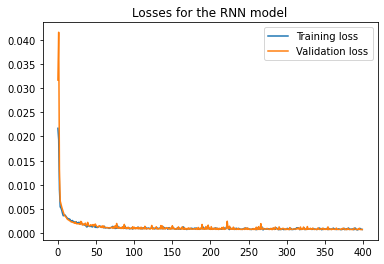

[1/400] Training loss: 0.0619	 Validation loss: 0.2380
[2/400] Training loss: 0.0268	 Validation loss: 0.1100
[3/400] Training loss: 0.0126	 Validation loss: 0.0377
[4/400] Training loss: 0.0172	 Validation loss: 0.0444
[5/400] Training loss: 0.0143	 Validation loss: 0.0432
[6/400] Training loss: 0.0115	 Validation loss: 0.0267
[7/400] Training loss: 0.0103	 Validation loss: 0.0175
[8/400] Training loss: 0.0084	 Validation loss: 0.0119
[9/400] Training loss: 0.0072	 Validation loss: 0.0084
[10/400] Training loss: 0.0059	 Validation loss: 0.0098
[50/400] Training loss: 0.0017	 Validation loss: 0.0024
[100/400] Training loss: 0.0011	 Validation loss: 0.0015
[150/400] Training loss: 0.0009	 Validation loss: 0.0012
[200/400] Training loss: 0.0009	 Validation loss: 0.0011
[250/400] Training loss: 0.0010	 Validation loss: 0.0016
[300/400] Training loss: 0.0009	 Validation loss: 0.0010
[350/400] Training loss: 0.0007	 Validation loss: 0.0009
[400/400] Training loss: 0.0007	 Validation loss: 0

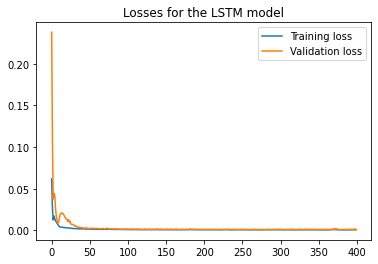

[1/400] Training loss: 0.0812	 Validation loss: 0.1425
[2/400] Training loss: 0.0091	 Validation loss: 0.0141
[3/400] Training loss: 0.0172	 Validation loss: 0.0472
[4/400] Training loss: 0.0098	 Validation loss: 0.0273
[5/400] Training loss: 0.0097	 Validation loss: 0.0191
[6/400] Training loss: 0.0087	 Validation loss: 0.0164
[7/400] Training loss: 0.0072	 Validation loss: 0.0104
[8/400] Training loss: 0.0066	 Validation loss: 0.0089
[9/400] Training loss: 0.0049	 Validation loss: 0.0074
[10/400] Training loss: 0.0046	 Validation loss: 0.0077
[50/400] Training loss: 0.0018	 Validation loss: 0.0026
[100/400] Training loss: 0.0011	 Validation loss: 0.0011
[150/400] Training loss: 0.0011	 Validation loss: 0.0012
[200/400] Training loss: 0.0008	 Validation loss: 0.0011
[250/400] Training loss: 0.0008	 Validation loss: 0.0011
[300/400] Training loss: 0.0009	 Validation loss: 0.0010
[350/400] Training loss: 0.0008	 Validation loss: 0.0011
[400/400] Training loss: 0.0014	 Validation loss: 0

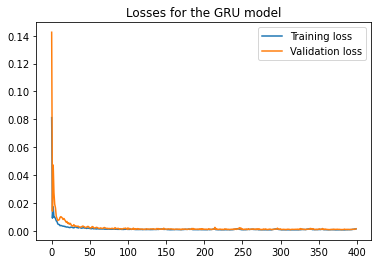

In [ ]:
#Train the models and plot the losses

input_dim = len(X_train.columns)
output_dim = 1
hidden_dim = 64
layer_dim = 3
batch_size = 64
dropout = 0.2
n_epochs = 400
learning_rate = 0.001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim' : hidden_dim,
                'layer_dim' : layer_dim,
                'output_dim' : output_dim,
                'dropout_prob' : dropout}

listofmodels=["rnn","lstm","gru"]
dictmodelspred={}
dictmodelsvalues={}
for i in listofmodels:
    model = get_model(i, model_params)

    loss_fn = nn.MSELoss(reduction="mean")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    opt = Optimization(model=model, loss_fn=loss_fn, optimizer=optimizer)
    opt.train(train_loader, val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
    opt.plot_losses()
    predictions, values = opt.evaluate(test_loader_one, batch_size=1, n_features=input_dim)
    dictmodelspred[i]=predictions
    dictmodelsvalues[i]=values

In [ ]:
#Bring back the data to their scale
def inverse_transform(scaler, df, columns):
    for col in columns:
        df[col] = scaler.inverse_transform(df[col])
    return df

#Put into a dataframe the actual closing and the predicted prices
def format_predictions(predictions, values, df_test, scaler):
    vals = np.concatenate(values, axis=0).ravel()
    preds = np.concatenate(predictions, axis=0).ravel()
    df_result = pd.DataFrame(data={"Closing_price": vals, "prediction": preds}, index=df_test.head(len(vals)).index)
    df_result = df_result.sort_index()
    df_result = inverse_transform(scaler, df_result, [["Closing_price", "prediction"]])
    return df_result

In [ ]:
# The actual closing and the predicted prices fpr each model
df_result_RNN = format_predictions(dictmodelspred['rnn'], dictmodelsvalues['rnn'], X_test, scaler)
df_result_GRU = format_predictions(dictmodelspred['gru'], dictmodelsvalues['gru'], X_test, scaler)
df_result_LSTM = format_predictions(dictmodelspred['lstm'], dictmodelsvalues['lstm'], X_test, scaler)

In [ ]:
# Function to calculate the MAE, RMSE and R^2
def calculate_metrics(df):
    return {'mae' : mean_absolute_error(df.Closing_price, df.prediction),
            'rmse' : mean_squared_error(df.Closing_price, df.prediction) ** 0.5,
            'r2' : r2_score(df.Closing_price, df.prediction)}

In [ ]:
result_metrics_RNN= calculate_metrics(df_result_RNN)
result_metrics_GRU= calculate_metrics(df_result_GRU)
result_metrics_LSTM= calculate_metrics(df_result_LSTM)
print(result_metrics_RNN)
print(result_metrics_GRU)
print(result_metrics_LSTM)

{'mae': 0.4641568, 'rmse': 0.6779114329771634, 'r2': 0.9264018149120202}
{'mae': 0.5253593, 'rmse': 0.7468810795492666, 'r2': 0.9106644990220988}
{'mae': 0.504477, 'rmse': 0.710263278395301, 'r2': 0.919209566504483}


The RNN model has the lower MAE and the RMSE and also the higher R^2. So the RNN model is the most accurate one. Furthermore, all the models have good accuracy, as we can also identify from the figure below.

In [ ]:
def plot_predictions(df_result, df_baseline,df_baseline2):
    data = []
    
    value = go.Scatter(
        x=df_result.index,
        y=df_result.Closing_price,
        mode="lines",
        name="values",
        marker=dict(),
        text=df_result.index,
        line=dict(color="rgba(0,0,0, 0.3)"),
    )
    data.append(value)

    baseline = go.Scatter(
        x=df_baseline.index,
        y=df_baseline.prediction,
        mode="lines",
        line={"dash": "dot"},
        name='GRU predictions',
        marker=dict(),
        text=df_baseline.index,
        opacity=0.8,
    )
    data.append(baseline)
    
    prediction = go.Scatter(
        x=df_result.index,
        y=df_result.prediction,
        mode="lines",
        line={"dash": "dashdot"},
        name='RNN predictions',
        marker=dict(),
        text=df_result.index,
        opacity=0.8,
    )
    data.append(prediction)
    baseline2 = go.Scatter(
        x=df_baseline2.index,
        y=df_baseline2.prediction,
        mode="lines",
        line={"dash": "longdash"},
        name='LSTM predictions',
        marker=dict(),
        text=df_baseline2.index,
        opacity=0.8,
    )
    data.append(baseline2)
    
    layout = dict(
        title="Predictions vs Actual Values for the dataset",
        xaxis=dict(title="Time", ticklen=5, zeroline=False),
        yaxis=dict(title="Value", ticklen=5, zeroline=False),
    )

    fig = dict(data=data, layout=layout)
    iplot(fig)
    plotly.offline.plot(fig, filename='models-chart.html')
    
    
# Set notebook mode to work in offline
pyo.init_notebook_mode()

plot_predictions(df_result_RNN, df_result_GRU,df_result_LSTM)